[0 1 2 3 4 5 6 7 8 9]
[6 1 2 3 4 5 6 7 8 9]
[6 1 2 3 4 5 6 7 8 2]
[6 1 2 3 4 7 6 7 8 2]
[6 1 2 3 8 7 6 7 8 2]
[6 6 2 3 8 7 6 7 8 2]
[71.19       54.85865973 40.33015414 29.40049882 21.4388964  16.3856496
 16.3856496 ]


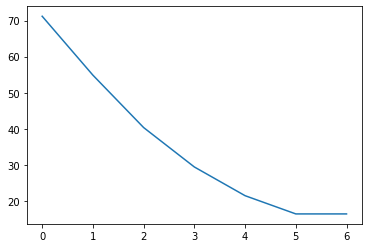

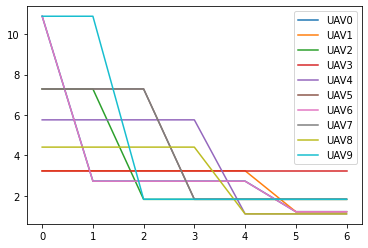

In [1]:
# Author : ZhuoYi Bai
# Date : 2020/12/02
# Email : oliverpai@163.com
# Content : Reproduction of the article "A Strategic Game for Task Offloading among Capacitated UAV-mounted Cloudlets"

import numpy as np
import matplotlib.pyplot as plt

## Constance
gamma = 1.2e-28
C_task = 3000*1e6
S_task = 420*1024

## Function: Calculate d_i[t], T_i[t], Z_i[t]
def calc_dTZ(y, P, F, B, numOfUAV):
    d = np.zeros(numOfUAV)                                      # 各无人机被卸载的任务数
    r = np.zeros(numOfUAV)                                      # 各无人机与其它无人机点对点带宽
    T = np.zeros(numOfUAV)                                      # 各无人机任务完成时间
    Z = np.zeros(numOfUAV)                                      # 各无人机任务完成所需能量
    x = np.zeros([numOfUAV, numOfUAV])                          # 各无人机之间任务卸载情况
    f = np.zeros(numOfUAV)                                      # 各无人机分配给一个任务的CPU频率
    for i in range(numOfUAV):
        x[i][y[i]] = 1
    for i in range(numOfUAV):
        d[i] = np.sum(x, axis = 0)[i] - x[i][i]                 # Calculate d_i
        r[i] = B[i] / (d[i] if d[i]!=0 else 1)
        f[i] = F[i] / (np.sum(x, axis = 0)[i] if np.sum(x, axis = 0)[i]!=0 else 1)    # axis=1是所有到i的无人机，axis=0是i到的所有无人机
    for i in range(numOfUAV):
        for j in range(numOfUAV):
            if j != i:
                T[i] = T[i] + (S_task/r[i] + C_task/f[j]) * x[i][j]
        T[i] = T[i] + C_task / f[i] * x[i][i]                   # Calculate T_i
    for i in range(numOfUAV):                                   # Calculate Z_i
        if y[i] == i:
            Z[i] = C_task * f[i]**2 * gamma
        else:
            Z[i] = S_task * P[i]/r[i] + C_task * f[y[i]]**2 * gamma
    return np.sum(x, axis = 0), T, Z


## Function: Strategic Offloading Algorithm
# def my_SOA(P, F, B, numOfUAV, T_max, U_cap):
#     ## Initialize
#     y = [i for i in range(numOfUAV)]

#     y_mat = np.zeros([numOfUAV, numOfUAV]).astype(int)
#     d_mat = np.zeros([numOfUAV, numOfUAV])
#     T_mat = np.zeros([numOfUAV, numOfUAV])
#     Z_mat = np.zeros([numOfUAV, numOfUAV])
#     t = 0
#     d, T, Z = calc_dTZ(y, P, F, B, numOfUAV)                # t
#     Z_result = Z
#     while 1:    
#         Z_prev = np.sum(Z)
#         #----------------- t + 1 ------------------
#         for i in range(numOfUAV):                               # UAV
#             best = y[i]
#             for j in range(numOfUAV):                           # u_i的不同选择
#                 error = 0
#                 y_mat[j] = y                                    # 存储改变y_i的所有可能
#                 y_mat[j][i] = j
#                 d_mat[j], T_mat[j], Z_mat[j] = calc_dTZ(y_mat[j], P, F, B, numOfUAV)
#                 for numtask in d_mat[j]:
#                     if numtask > U_cap[i]:
#                         error = 1
#                         break
#                 for numtime in T_mat[j]:
#                     if numtime > T_max[i]:
#                         error = 1
#                         break
#                 if error != 1:
#                     if np.sum(Z_mat[j]) < np.sum(Z_mat[best]):
#                         best = j
#                 else:
#                     error  = 0
#             y = y_mat[best]
#             Z_result = np.vstack([Z_result, Z_mat[best]])
#         d, T, Z = calc_dTZ(y, P, F, B, numOfUAV)
#         if Z_prev <= np.sum(Z):
#             return t, Z_result, y
#         t = t + 1


## Function: Strategic Offloading Algorithm
def real_SOA(P, F, B, numOfUAV, T_max, U_cap):
    ## Initialize
    y = [i for i in range(numOfUAV)]

    y_mat = np.zeros([numOfUAV, numOfUAV]).astype(int)
    d_mat = np.zeros([numOfUAV, numOfUAV])
    T_mat = np.zeros([numOfUAV, numOfUAV])
    Z_mat = np.zeros([numOfUAV, numOfUAV])

    t = 1
    d, T, Z = calc_dTZ(y, P, F, B, numOfUAV)                # t
    Z_result = Z
    
    while 1:    
        print(np.array(y))
        y_temp = y
        Z_temp = Z
        Z_prev = np.sum(Z)
        #----------------- t + 1 ------------------
        for i in range(numOfUAV):                               # UAV
            best = y[i]
            for j in range(numOfUAV):                           # u_i的不同选择
                error = 0
                y_mat[j] = y                                    # 存储改变y_i的所有可能
                y_mat[j][i] = j
                d_mat[j], T_mat[j], Z_mat[j] = calc_dTZ(y_mat[j], P, F, B, numOfUAV)
                for numtask in d_mat[j]:
                    if numtask > U_cap[i]:
                        error = 1
                        break
                for numtime in T_mat[j]:
                    if numtime > T_max[i]:
                        error = 1
                        break
                if error != 1:
                    if np.sum(Z_mat[j]) < np.sum(Z_mat[best]):
                        best = j
                else:
                    error  = 0
            y_temp = np.vstack([y_temp, y_mat[best]])
            Z_temp = np.vstack([Z_temp, Z_mat[best]])
        iter_best = np.argmin(np.sum(Z_temp, axis = 1))
        y = y_temp[iter_best]
        Z_result = np.vstack([Z_result, Z_temp[iter_best]])
        d, T, Z = calc_dTZ(y, P, F, B, numOfUAV)
        
        if Z_prev <= np.sum(Z):
            return t, Z_result, y
        t = t + 1


## Variable
numOfUAV = 10                                                   # 无人机数量
numOfTask = numOfUAV                                            # 任务数

F = 3 + 0.5 * np.random.randint(0, 6, size=numOfUAV)            # 每台无人机的CPU频率
F = F * 1e9
U_cap = np.random.randint(1, 10, size=numOfUAV)                 # 每台无人机任务容量
mu = 5
sigma = 0.15 * mu
B = sigma * np.random.randn(numOfUAV) + mu                      # 每台无人机可用带宽
B = B * 5e6
T_max = np.random.randint(2, 10, size=numOfTask)                # 每个任务允许的最长执行时间
P = 0.05 * np.random.randint(1, 10, size=numOfUAV)              # 每台无人机的传输功率

## main
[numOfIter, Z_result, y_result] = real_SOA(P, F, B, numOfUAV, T_max, U_cap)

All_Energy = np.sum(Z_result,axis = 1)
# print(numOfIter)
print(np.sum(Z_result, axis=1))
# print(y_result)
fig1 = plt.figure()
plt.plot(range(np.size(All_Energy)), All_Energy)
plt.show()
fig2 = plt.figure()
for i in range(numOfUAV):
    plt.plot(range(np.size(Z_result[:,i])), Z_result[:,i], label="UAV"+str(i))
plt.legend()
plt.show()